In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
def get_data():
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    ldata_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
    ldata_dir = pathlib.Path(ldata_dir)

    return ldata_dir

In [3]:
def save_model(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights("model.h5")
    print("Saved model to disk")


def retrieve_model():
    print('retrieving model')

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")

    return loaded_model

In [4]:
data_dir = get_data()
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
img_height = 180
img_width = 180
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
class_names = train_ds.class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

'''for better performance'''
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2021-12-24 10:45:03.263872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-24 10:45:03.265485: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


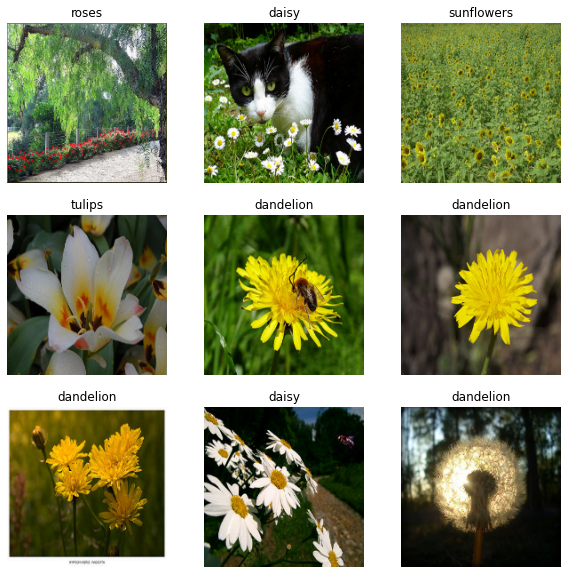

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
num_classes = len(class_names)
from tensorflow.python.keras.callbacks import TensorBoard 
from datetime import date

In [9]:
def generate_model(gene):
    model = Sequential()
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))
    for i in range (gene[0]):
        print('da')
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        if gene[i+1] == 1:
            model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    # model.summary()
    return model

In [10]:
''' train '''
def train(model, epochs, nmb_of_generation, gene):
    # log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    today = date.today()

    # dd/mm/YY
    d1 = today.strftime("%d-%m-%Y")
    # tensorboard = TensorBoard(log_dir=)
    
    log = "logs/" + str(d1) + "/"+ str(nmb_of_generation) + "/" + str(gene)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log, histogram_freq=1)
    # loss_history = LossHistory()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,
        callbacks=[tensorboard_callback]
    )
    return history.history['val_accuracy']

In [11]:
def generate_initial_generation(nmb_indiv):
    arr = []
    for i in range(nmb_indiv):
        while True:
            nmb_layers = np.array([np.random.randint(2,6)])
            gene = np.random.randint(2,size=nmb_layers)
            poz_for_maxpooling = np.random.randint(0,nmb_layers)
            gene[poz_for_maxpooling] = 1
            gene = np.concatenate((nmb_layers, gene), axis=0)
            
            ok = True
            for el in arr:
                if np.array_equal(el, gene):
                    ok = False
            if ok:
                break
            
        arr.append(gene)
    arr = np.asarray(arr)
    print('Individuals:')
    print(arr)
    return arr

In [12]:

generate_initial_generation(11)

Individuals:
[array([5, 1, 1, 1, 1, 1]) array([3, 1, 1, 0]) array([2, 1, 0])
 array([4, 0, 1, 1, 1]) array([2, 1, 1]) array([4, 1, 1, 1, 1])
 array([3, 1, 0, 1]) array([5, 1, 1, 1, 0, 0]) array([2, 0, 1])
 array([5, 0, 1, 1, 1, 0]) array([3, 0, 1, 1])]


/Users/andreighiurtu/miniforge3/envs/tf2/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


array([array([5, 1, 1, 1, 1, 1]), array([3, 1, 1, 0]), array([2, 1, 0]),
       array([4, 0, 1, 1, 1]), array([2, 1, 1]), array([4, 1, 1, 1, 1]),
       array([3, 1, 0, 1]), array([5, 1, 1, 1, 0, 0]), array([2, 0, 1]),
       array([5, 0, 1, 1, 1, 0]), array([3, 0, 1, 1])], dtype=object)

In [24]:
import random


def mutation(mutation_rate, offspring):
    mutation_point = random.randint(0, offspring[0])
    print('mutation')
    print(offspring)
    print(mutation_point)
    is_mutated = random.randint(1, 100)
    if is_mutated < mutation_rate*100:
        if mutation_point != 0:
            offspring[mutation_point] = 1 - offspring[mutation_point]
        else:
            if offspring[0] == 2:
                rand = 1
            elif offspring[0] == 5:
                rand = 0
            else:
                rand = random.randint(0, 1)
                
            if rand==0:
                offspring = offspring[:-1]
                offspring[0] = offspring[0] - 1
            else:
                addon = random.randint(0, 1)
                offspring = np.append(offspring, addon)
                offspring[0] = offspring[0] + 1 
    return offspring
    

def create_offspring(parent1, parent2, crossover_point):
    offspring = []
    print('offspring:')
    print(parent1)
    print(parent2)
    print(crossover_point)
    offspring.append(parent1[0])
    if crossover_point != parent1[0]:
        offspring = np.append(offspring, parent2[1:(crossover_point+1)])
        offspring = np.append(offspring, parent1[(crossover_point+1):])
    else:
        offspring = np.append(offspring, parent2[1:(crossover_point+1)])

    return offspring


def update_generation(population, fitness, nmb_ind, mutation_rate):
    # code cleanup, mutatia, prima antrenare  
    new_population = []
    pop=[]
    for idx, el in enumerate(population):
        pop.append([el, fitness[idx]])
        
    for i in range(int(nmb_ind/2)):
        parents = random.sample(pop, k=4) 
        parents = sorted(parents, key=lambda agent: agent[1], reverse=True)
        crossover_point = random.randint(0, min(parents[0][0][0], parents[1][0][0]))
        
        par1 = parents[0][0]
        par2 = parents[1][0]
        
        off1 = create_offspring(par1, par2, crossover_point)
        off2 = create_offspring(par2, par1, crossover_point)
        new_population.append(mutation(mutation_rate, off1))
        new_population.append(mutation(mutation_rate, off2))
        
    new_population = np.asarray(new_population)
    return new_population

In [14]:
pop = np.array([[2, 0, 0],
               [3, 0, 1, 1],
               [4, 0, 1, 0, 1],
               [5, 0, 1, 1, 0, 1],
               [2, 1, 1],
               [4, 1, 0, 0, 1]])

fit = np.array([2, 6, 5, 2, 3, 7])
print(update_generation(pop, fit, 6, 0.25))

offspring:
[4, 1, 0, 0, 1]
[3, 0, 1, 1]
3
offspring:
[3, 0, 1, 1]
[4, 1, 0, 0, 1]
3
mutation
[4, 0, 1, 1, 1]
4
mutation
[3, 1, 0, 0]
0
offspring:
[4, 1, 0, 0, 1]
[3, 0, 1, 1]
1
offspring:
[3, 0, 1, 1]
[4, 1, 0, 0, 1]
1
mutation
[4, 0, 0, 0, 1]
2
mutation
[3, 1, 1, 1]
2
offspring:
[4, 1, 0, 0, 1]
[3, 0, 1, 1]
2
offspring:
[3, 0, 1, 1]
[4, 1, 0, 0, 1]
2
mutation
[4, 0, 1, 0, 1]
4
mutation
[3, 1, 0, 1]
2
[list([4, 0, 1, 1, 1]) list([3, 1, 0, 0]) list([4, 0, 1, 0, 1])
 list([3, 1, 1, 1]) list([4, 0, 1, 0, 0]) list([3, 1, 0, 1])]


/var/folders/yy/d05rnqtj1js1wc4gfj4djn400000gn/T/ipykernel_26554/1387667397.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pop = np.array([[2, 0, 0],


In [15]:
def train_by_GA(nmb_of_generations, nmb_ind_per_gen, nmb_of_epochs, mutation_rate):
    population = np.array(generate_initial_generation(nmb_ind_per_gen))
    print(population)
    fitness = np.zeros(nmb_ind_per_gen)
    for gen in range(nmb_of_generations):
        for idx_ind, gene in enumerate(population):
            model = generate_model(gene)
            hist = train(model, nmb_of_epochs, gen+1, gene) 
            fitness[idx_ind] = hist[nmb_of_epochs-1]
        population = update_generation(population, fitness,  nmb_ind_per_gen, mutation_rate)
        

In [26]:
train_by_GA(nmb_of_generations=2,nmb_ind_per_gen=4,nmb_of_epochs=1, mutation_rate=0.25)

Individuals:
[array([5, 1, 1, 1, 1, 1]) array([5, 0, 1, 1, 1, 1]) array([3, 1, 1, 0])
 array([2, 1, 1])]
[array([5, 1, 1, 1, 1, 1]) array([5, 0, 1, 1, 1, 1]) array([3, 1, 1, 0])
 array([2, 1, 1])]
da
da
da
da
da


2021-12-24 11:04:33.888551: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:04:33.888565: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:04:33.888600: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:04:34.764965: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:04:34.764995: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:04:35.109856: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:04:35.110884: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:04:35.111995: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/1/[5 1 1 1 1 1]/train/plugins/profile/2021_12_24_11_04_35

2021-12-24 11:04:35.113682:

da
da
da
da
da


2021-12-24 11:05:08.317067: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:05:08.317077: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:05:08.317115: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:05:09.584882: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:05:09.584893: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:05:10.498854: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:05:10.500812: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:05:10.502085: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/1/[5 0 1 1 1 1]/train/plugins/profile/2021_12_24_11_05_10

2021-12-24 11:05:10.503906:

da
da
da


2021-12-24 11:06:27.876183: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:06:27.876192: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:06:27.876229: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:06:28.567018: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:06:28.567032: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:06:28.904327: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:06:28.905294: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:06:28.906430: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/1/[3 1 1 0]/train/plugins/profile/2021_12_24_11_06_28

2021-12-24 11:06:28.909212: I t

da
da


2021-12-24 11:07:00.633327: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:07:00.633338: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:07:00.633436: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:07:01.159091: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:07:01.159102: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:07:01.476299: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:07:01.477373: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:07:01.478745: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/1/[2 1 1]/train/plugins/profile/2021_12_24_11_07_01

2021-12-24 11:07:01.480396: I ten

offspring:
[5 0 1 1 1 1]
[3 1 1 0]
1
offspring:
[3 1 1 0]
[5 0 1 1 1 1]
1
mutation
[5 1 1 1 1 1]
0
mutation
[3 0 1 0]
2
offspring:
[5 0 1 1 1 1]
[3 1 1 0]
1
offspring:
[3 1 1 0]
[5 0 1 1 1 1]
1
mutation
[5 1 1 1 1 1]
1
mutation
[3 0 1 0]
3
da
da
da
da
da


2021-12-24 11:07:27.851229: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:07:27.851239: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:07:27.851326: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:07:28.485115: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:07:28.485126: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:07:28.765249: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:07:28.766463: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:07:28.767932: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/2/[5 1 1 1 1 1]/train/plugins/profile/2021_12_24_11_07_28

2021-12-24 11:07:28.769326:

da
da
da


2021-12-24 11:07:58.158564: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:07:58.158574: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:07:58.158607: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:07:59.685326: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:07:59.685348: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:08:00.503732: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:08:00.504982: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:08:00.506359: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/2/[3 0 1 0]/train/plugins/profile/2021_12_24_11_08_00

2021-12-24 11:08:00.508035: I t

da
da
da
da
da


2021-12-24 11:09:26.175924: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:09:26.175932: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:09:26.176013: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:09:27.237359: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:09:27.237369: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:09:27.968663: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:09:27.970295: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:09:27.971627: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/2/[5 0 1 1 1 1]/train/plugins/profile/2021_12_24_11_09_27

2021-12-24 11:09:27.973231:

da
da
da


2021-12-24 11:10:31.877038: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:10:31.877047: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:10:31.877086: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:10:33.000529: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-24 11:10:33.000544: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-24 11:10:33.838776: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-24 11:10:33.841090: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-24 11:10:33.842399: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/24-12-2021/2/[3 0 1 0]/train/plugins/profile/2021_12_24_11_10_33

2021-12-24 11:10:33.846417: I t

offspring:
[3 0 1 0]
[5 1 1 1 1 1]
1
offspring:
[5 1 1 1 1 1]
[3 0 1 0]
1
mutation
[3 1 1 0]
0
mutation
[5 0 1 1 1 1]
5
offspring:
[3 0 1 0]
[5 1 1 1 1 1]
3
offspring:
[5 1 1 1 1 1]
[3 0 1 0]
3
mutation
[3 1 1 1]
2
mutation
[5 0 1 0 1 1]
5
